# Computed Tomography Simulator

In [1]:
import io
from skimage.util import img_as_int
from matplotlib import pylab as plt
from math import pi
from PIL import Image, ImageOps
import IPython.core.display
from IPython.core.display import display, HTML
from IPython.display import clear_output
import numpy as np
import pydicom
from pydicom.data import get_testdata_file
from pydicom.filebase import DicomBytesIO
import ipywidgets as widgets

In [2]:
# input parameters
alfa = 0
detectors = 0 
phi = 0
iterations = 0
filtering = False
animation = False

# other parameters
theta = 180.

In [3]:
def getParallelEmittersPositions(image, angle, phi, detectors):
    angle = np.deg2rad(angle)
    phi_rad = np.deg2rad(phi)
    positions = []
    r = max(image.shape) * np.sqrt(2) / 2
    center = max(image.shape) / 2

    for i in range(detectors):
        x = int(r * np.cos(angle + phi_rad / 2 - i * (phi_rad / (detectors - 1))) + center)
        y = int(r * np.sin(angle + phi_rad / 2 - i * (phi_rad / (detectors - 1))) + center)
        positions.append([x, y])

    return positions

def getDetectorsPositions(image, angle, phi, detectors): 
    angle_rad = np.deg2rad(angle)
    phi_rad = np.deg2rad(phi)
    positions = []
    r = max(image.shape) * np.sqrt(2) / 2 
    center = max(image.shape) / 2
    
    for i in range(detectors):
        x = int(r * np.cos(angle_rad + np.pi - phi_rad / 2 + i * (phi_rad / (detectors - 1))) + center) 
        y = int(r * np.sin(angle_rad + np.pi - phi_rad / 2 + i * (phi_rad / (detectors - 1))) + center)
        positions.append([x, y])
    
    return positions

def applyBresenhamAlgorithm(x0, y0, x1, y1): 
    delta_x = x1 - x0
    delta_y = y1 - y0     
    x_direction = 1
    y_direction = 1
    line = []
    
    if delta_x < 0:
        delta_x, x_direction = abs(delta_x), -1     
                                                       
    if delta_y < 0:
        delta_y, y_direction = abs(delta_y), -1    
    
    error = delta_y - delta_x 
    y = y0 
    x = x0 
        
    if delta_x > delta_y:
        for _ in range(delta_x):
            line.append([x, y])
            if error >= 0:
                y += y_direction
                error -= delta_x
            x += x_direction
            error += delta_y
    else:
        for _ in range(delta_y):
            line.append([x, y])
            if error >= 0:
                x += x_direction
                error -= delta_y
            y += y_direction
            error += delta_x
    
    return line

def isCorrectPoint(image, x, y):
    if x >= 0 and y >= 0 and x < image.shape[0] and y < image.shape[1]:
        return True
    return False

def createFilterMask():
    mask = []
    mask_size = 9
    
    if mask_size % 2 == 0:
        mask_size += 1
    
    for k in range(- mask_size // 2 + 1, mask_size // 2 + 1, 1):
        if k == 0:
            mask.append(1)
        elif k % 2 == 0:
            mask.append(0)
        else:
            mask.append((-4 / (pi * pi)) / (k * k))
    
    return mask 

def filterImage(sinogram):
    mask = createFilterMask()
    
    for i in range(sinogram.shape[0]):
        sinogram[i, :] = np.convolve(sinogram[i, :], mask, 'same')
        
    return sinogram

def normalize(array):             
    min_value = np.amin(array)
    max_value = np.amax(array)
    
    if min_value == max_value:
        return array
    
    for i in range(len(array)):
        for j in range(len(array[i])):
            array[i][j] = (array[i][j] - min_value) / (max_value-min_value)
        
    return array

def applyRadonTransform(image, iterations, phi, detectors, animation):    
    sinogram = np.zeros((iterations, detectors))
    angles = np.linspace(0., theta, iterations, endpoint=False)
    
    images_animation = []

    for i, angle in enumerate(angles):
        em_pos = getParallelEmittersPositions(image, angle, phi, detectors)
        det_pos = getDetectorsPositions(image, angle, phi, detectors)
        detectors_output = []
        
        for em, det in zip(em_pos, det_pos):
            pixels_sum = 0
            line = applyBresenhamAlgorithm(em[0], em[1], det[0], det[1])
            
            for point in line:
                if isCorrectPoint(image, point[0], point[1]):
                    pixels_sum += image[point[0], point[1]]         
                                                                    
            detectors_output.append(pixels_sum)
        
        sinogram[i] = detectors_output
        
        if animation:
            sinogram_animation = sinogram.copy()
            sinogram_animation = np.array(normalize(sinogram_animation))
            im = Image.fromarray(sinogram_animation * 255)
            images_animation.append(im)
    
    if animation:
        images_animation[0].save('sinogram.gif', save_all = True, append_images = images_animation[1:])
         
    return np.array(normalize(sinogram))

def applyInverseRadonTransform(image, sinogram, iterations, phi, detectors, filtering, animation):           
    output = np.zeros((image.shape[0], image.shape[1]))
    angles = np.linspace(0., theta, iterations, endpoint=False)
    
    images_animation = []
    
    if filtering:
        sinogram = filterImage(sinogram.copy())
    
    for i, angle in enumerate(angles):
        em_pos = getParallelEmittersPositions(image, angle, phi, detectors)
        det_pos = getDetectorsPositions(image, angle, phi, detectors)
        
        for j, (em, det) in enumerate(zip(em_pos, det_pos)):
            line = applyBresenhamAlgorithm(em[0], em[1], det[0], det[1])
            pixels_sum = sinogram[i][j]
            
            for point in line:                 
                if isCorrectPoint(image, point[0], point[1]):
                    output[point[0], point[1]] += pixels_sum     
        
        if animation:
            output_animation = output.copy()
            output_animation = np.array(normalize(output_animation))
            im = Image.fromarray(output_animation * 255)
            images_animation.append(im)
        
    if animation:
        images_animation[0].save('output.gif', save_all = True, append_images = images_animation[1:])
        
    return normalize(output)

def writeDicom(output, filename, firstName, lastName, patientID, sex, birthDate, studyDate, comment):
    output = img_as_int(output)
    filect = get_testdata_file('CT_small.dcm')
    ds = pydicom.dcmread(filect)
    
    ds.PatientName = '{}^{}'.format(lastName, firstName)
    ds.PatientID = patientID
    ds.PatientSex = sex
    ds.PatientBirthDate = birthDate
    ds.StudyDate = studyDate
    
    ds.Rows, ds.Columns = output.shape[0], output.shape[1]
    ds.PixelRepresentation = 0
    ds.BitsAllocated = 16
    ds.BitsStored = 16
    ds.HighBit = 15
    ds.PixelData = output.tobytes()
    ds.ImageComments = comment
    
    ds.save_as(filename)
    
def calculateRootMeanSquaredError(output):
    rmse = 0.0
    n = image.shape[0] * image.shape[1]
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rmse += (image[i][j] - output[i][j]) ** 2 
            
    return np.sqrt(rmse / n)         


In [4]:
imageUpload = widgets.FileUpload(accept='image/*',
                                 multiple=False)

dicomUpload = widgets.FileUpload(accept='.dcm',
                                 multiple=False,
                                 description='Upload DICOM file')

alphaSlider = widgets.IntSlider(value=1,
                               min=1,
                               max=10,
                               step=1)
detectorsAmountSlider = widgets.IntSlider(value=300,
                                   min=100,
                                   max=500,
                                   step=10)
detectorsSpanSlider = widgets.IntSlider(value=120,
                                        min=90,
                                        max=180,
                                        step=10)
sliderBox = widgets.HBox(
    [widgets.VBox([widgets.Label('Upload image'), 
                   widgets.Label('Delta alpha'), 
                   widgets.Label('Detectors amount'), 
                   widgets.Label('Detectors angular span')]), 
     widgets.VBox([imageUpload, 
                   alphaSlider, 
                   detectorsAmountSlider, 
                   detectorsSpanSlider])
    ])

filteringCheckbox = widgets.Checkbox(value=False, description='Enable filtering')
animationCheckbox = widgets.Checkbox(value=False, description='Enable animation')

filenameText = widgets.Text()
firstNameText = widgets.Text()
lastNameText = widgets.Text()
patientIDText = widgets.Text()
sexText = widgets.Text()
birthDateText = widgets.Text()
studyDateText = widgets.Text()
commentText = widgets.Textarea()

dicomBox = widgets.HBox(
    [widgets.VBox([widgets.Label('filename'), 
                   widgets.Label('first name'),
                   widgets.Label('last name'),
                   widgets.Label('ID'),
                   widgets.Label('sex'),
                   widgets.Label('birth date'),
                   widgets.Label('study date'),
                   widgets.Label('comments')]),
     widgets.VBox([filenameText,
                   firstNameText,
                   lastNameText,
                   patientIDText,
                   sexText,
                   birthDateText,
                   studyDateText,
                   commentText])
    ])

In [5]:
def processImage():
    display(sliderBox)
    display(filteringCheckbox)
    display(animationCheckbox)

    processButton = widgets.Button(description='Process image')
    output = widgets.Output()
    output2 = widgets.Output()
    display(processButton, output, output2)
    
    def onProcessButton(b):
        with output:
            for uploaded_filename in imageUpload.value:
                clear_output(wait = True)
                content = imageUpload.value[uploaded_filename]['content']
                image = Image.open(io.BytesIO(content))
                image = ImageOps.grayscale(image)
                image = np.asarray(image)
            
        alfa = alphaSlider.value
        detectors = detectorsAmountSlider.value
        phi = detectorsSpanSlider.value
        iterations = int(theta / alfa)
        filtering = filteringCheckbox.value
        animation = animationCheckbox.value
        
        sinogram = applyRadonTransform(image, iterations, phi, detectors, animation)
        result = applyInverseRadonTransform(image, sinogram, iterations, phi, detectors, filtering, animation)
        
        fig = plt.figure(figsize=(14, 4), dpi=80)
        ax = fig.add_subplot(131)
        ax.set_title('Input image')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.imshow(image, cmap='gray')
        
        ax = fig.add_subplot(132)
        ax.set_title('Sinogram')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Detector')
        ax.imshow(sinogram, cmap='gray')
        
        ax = fig.add_subplot(133)
        ax.set_title('Output image')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.imshow(result, cmap='gray')
        
        if animation:
            f = open('sinogram.gif', 'rb')
            f = f.read()
            img = widgets.Image(value = f, width = 200)
            display(img)
            f = open('output.gif', 'rb')
            f = f.read()
            img = widgets.Image(value = f, width = 200)
            display(img)

        display(dicomBox)
        dicomSaveButton = widgets.Button(description='Save DICOM')
        display(dicomSaveButton)

        def onSaveDicomButton(b):
            writeDicom(result,
                      filenameText.value,
                      firstNameText.value,
                      lastNameText.value,
                      patientIDText.value,
                      sexText.value,
                      birthDateText.value,
                      studyDateText.value,
                      commentText.value)
        
        dicomSaveButton.on_click(onSaveDicomButton)           

    processButton.on_click(onProcessButton)

### Image processing

Checkbox(value=False, description='Enable filtering')

Checkbox(value=False, description='Enable animation')

Button(description='Process image', style=ButtonStyle())

Output()

Output()

Image(value=b'GIF87ad\x00$\x00\x83\x00\x00\x00\x00\x00\x1a\x1a\x1a___\x99\x99\x99\xae\xae\xae\xc3\xc3\xc3\xd1\…

Image(value=b'GIF87a\x90\x01\x90\x01\x84\x00\x00\x00\x00\x00\x03\x03\x03GGGcccfffmmmuuuxxx\x9b\x9b\x9b\xbe\xbe…

Button(description='Save DICOM', style=ButtonStyle())

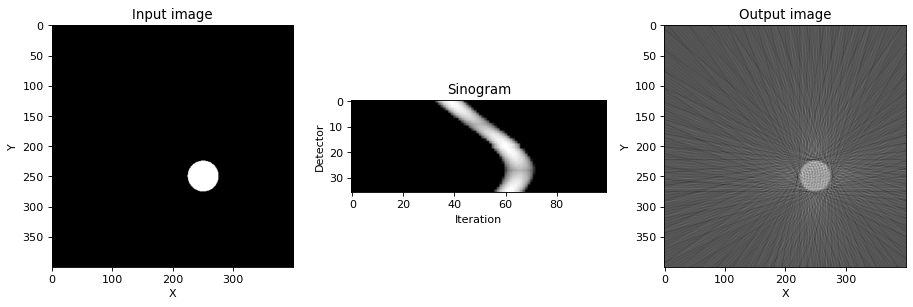

In [6]:
processImage()

In [7]:
def processDicom():
    laodDicomButton = widgets.Button(description='Read DICOM file')
    display(dicomUpload)
    display(laodDicomButton)

    def onLoadDicomButton(b):
        picture = False
        for uploaded_filename in dicomUpload.value:
            content = dicomUpload.value[uploaded_filename]['content']
            raw = DicomBytesIO(content)
            dt = pydicom.dcmread(raw)
        
        for item in dt:
            if item.keyword == 'PatientID':
                print('Patient ID: ' + dt.PatientID)
            elif item.keyword == 'PatientName':
                print('Patient name: ' + dt.PatientName.given_name + ' ' + dt.PatientName.family_name)
            elif item.keyword == 'PatientSex':
                print('Patient sex: ' + dt.PatientSex)
            elif item.keyword == 'PatientBirthDate':
                print('Patient birth date: ' + dt.PatientBirthDate)
            elif item.keyword == 'StudyDate':
                print('Study date: ' + dt.StudyDate)
            elif item.keyword == 'ImageComments':
                print('Comments: ' + dt.ImageComments)
            elif item.keyword == 'PixelData':
                picture = True

        if picture:
            plt.imshow(dt.pixel_array, cmap='gray')
    laodDicomButton.on_click(onLoadDicomButton)

### DICOM reading

In [8]:
processDicom()

FileUpload(value={}, accept='.dcm', description='Upload DICOM file')

Button(description='Read DICOM file', style=ButtonStyle())